Задание 1: Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

Задание 2: (опция). Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

Задание 3: (опция). Реализовать алгоритм градиетного бустинга, основанный на реализации решающего дерева из ДЗ4 / методички к уроку 4. Сделать выводы о качестве алгоритма по сравнению с реализацией из п.1.

In [1]:
import matplotlib.pyplot as plt
import random
from typing import TypeVar, Tuple
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn import model_selection
import numpy as np

from sklearn.datasets import load_diabetes

In [2]:
X, y = load_diabetes(return_X_y=True)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)


In [3]:
class Node:
    Node = TypeVar('Node', bound='Node')

    def __init__(self,
                 index: int,
                 t: float,
                 true_branch: Node,
                 false_branch: Node) -> None:
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле


class RegressorLeaf:

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        prediction = np.mean(self.labels)
        return prediction


class TreeBuilder:
    _leaf = None

    def __init__(self,
                 max_depth: int = None,
                 min_samples_leaf: int = 1,
                 min_samples_split: int = 2) -> None:
        self.max_depth = max_depth
        self.min_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split
        self._tree = None
        self.tree_depth = 0
        self.criterion = None

    def quality(self,
                left_y: np.array,
                right_y: np.array,
                current_criteria: float) -> float:
        p = float(left_y.shape[0]) / (left_y.shape[0] + right_y.shape[0])
        return current_criteria - p * self.criterion(left_y) - (1 - p) * self.criterion(right_y)

    @staticmethod
    def split(X: np.array,
              y: np.array,
              index: int,
              t: int) -> Tuple[np.array, np.array, np.array, np.array]:

        left = np.where(X[:, index] <= t)
        right = np.where(X[:, index] > t)

        true_data, false_data = X[left], X[right]
        true_labels, false_labels = y[left], y[right]

        return true_data, false_data, true_labels, false_labels

    def find_best_split(self, data, labels):

        current_criteria = self.criterion(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue

                current_quality = self.quality(true_labels, false_labels, current_criteria)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

    def build_tree(self, data, labels):

        quality, t, index = self.find_best_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return self._leaf(data, labels)

        if self.max_depth and self.tree_depth >= self.max_depth:
            return self._leaf(data, labels)

        if len(data) <= self.min_samples_split:
            return self._leaf(data, labels)

        self.tree_depth += 1

        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels)
        false_branch = self.build_tree(false_data, false_labels)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)

    def classify_object(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, self._leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)

    def predict(self, data):

        classes = []
        for obj in data:
            prediction = self.classify_object(obj, self._tree)
            classes.append(prediction)
        return classes

    @staticmethod
    def accuracy_metric(actual, predicted):
        return np.mean(np.where(actual == predicted, 1, False)) * 100.0

        # Напечатаем ход нашего дерева

    def _print_tree(self, node, spacing=""):

        # Если лист, то выводим его прогноз
        if isinstance(node, self._leaf):
            print(spacing + "Прогноз:", node.prediction)
            return

        # Выведем значение индекса и порога на этом узле
        print(spacing + 'Индекс', str(node.index))
        print(spacing + 'Порог', str(node.t))

        # Рекурсионный вызов функции на положительном поддереве
        print(spacing + '--> True:')
        self._print_tree(node.true_branch, spacing + "  ")

        # Рекурсионный вызов функции на положительном поддереве
        print(spacing + '--> False:')
        self._print_tree(node.false_branch, spacing + "  ")

    def print_tree(self):
        return self._print_tree(self._tree)

    def fit(self, data, labels):
        self._tree = self.build_tree(data, labels)
        return self


class DecisionTreeRegressor(TreeBuilder):
    _leaf = RegressorLeaf

    def __init__(self,
                 max_depth: int = None,
                 min_samples_leaf: int = 1,
                 min_samples_split: int = 2,
                 ) -> None:
        super().__init__(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
        self.criterion = self.variance

    @staticmethod
    def variance(y: np.array) -> float:
        return float(np.std(y))


In [48]:
class GradientBoostingRegressor:

    def __init__(self,
                 learning_rate: float = 1,
                 n_estimators: int = 10,
                 min_samples_split: int = 2,
                 min_samples_leaf: int = 2,
                 batch_size: int = 32,
                 random_state: int = None,
                 max_depth: int = 3) -> None:
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.batch_size = batch_size
        np.random.seed(random_state)
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split
        self._trees = None
        self._coefs = [1] * n_estimators
        self.train_errors = None
        self.test_errors = None

    def predict(self,
                X: np.array) -> np.array:
        # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
        # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
        return np.array(
            [sum([self.learning_rate * coef * alg.predict([x])[0] for alg, coef
                  in zip(self._trees, self._coefs)]) for x in X])

    @staticmethod
    def mean_squared_error(y_train, y_pred):
        return np.mean(np.square(y_train - y_pred))

    @staticmethod
    def bias(y, z):
        return y - z

    def fit(self, X_train, X_test, y_train, y_test):
        # Деревья будем записывать в список
        self._trees = []

        # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
        self.train_errors = []
        self.test_errors = []
        n_samples = y_train.shape[0]//self.batch_size

        if y_train.shape[0] % self.n_estimators:
            n_samples += 1

        indexes = np.arange(y_train.shape[0])
        oob_index = set(indexes)
        for i in range(self.n_estimators):
            tree = DecisionTreeRegressor(max_depth=self.max_depth,
                                         min_samples_leaf=self.min_samples_leaf,
                                         min_samples_split=self.min_samples_split)

            # инициализируем бустинг начальным алгоритмом, возвращающим ноль,
            # поэтому первый алгоритм просто обучаем на выборке и добавляем в список

            np.random.shuffle(indexes)
            x_batch = X_train[indexes[:n_samples]]
            y_batch = y_train[indexes[:n_samples]]

            if len(oob_index) > n_samples//2:
                oob_index -= set(indexes[:n_samples])

            if not self._trees:
                # обучаем первое дерево на обучающей выборке
                tree.fit(x_batch, y_batch)

                self.train_errors.append(self.mean_squared_error(y_train, self.predict(X_train)))
                self.test_errors.append(self.mean_squared_error(y_test, self.predict(X_test)))
            else:
                # Получим ответы на текущей композиции

                target = self.predict(x_batch)

                # алгоритмы начиная со второго обучаем на сдвиг
                tree.fit(x_batch, self.bias(y_batch, target))

                self.train_errors.append(self.mean_squared_error(y_train, self.predict(X_train)))
                self.test_errors.append(self.mean_squared_error(y_train[list(oob_index)], self.predict(X_train[list(oob_index)])))

            self._trees.append(tree)

        return self


    def evaluate(self, X_train, X_test, y_train, y_test):
        train_prediction = self.predict(X_train)

        print(f'Ошибка алгоритма из {self.n_estimators} деревьев глубиной {self.max_depth} \
        с шагом {self.learning_rate} на тренировочной выборке: {self.mean_squared_error(y_train, train_prediction)}')

        test_prediction = self.predict(X_test)

        print(f'Ошибка алгоритма из {self.n_estimators} деревьев глубиной {self.max_depth} \
        с шагом {self.learning_rate} на тестовой выборке: {self.mean_squared_error(y_test, test_prediction)}')

    def error_plot(self):
        plt.xlabel('Iteration number')
        plt.ylabel('MSE')
        plt.xlim(0, self.n_estimators)
        plt.plot(list(range(self.n_estimators)), self.train_errors, label='train error')
        plt.plot(list(range(self.n_estimators)), self.test_errors, label='test error')
        plt.legend(loc='upper right')
        plt.show()


Ошибка алгоритма из 200 деревьев глубиной 3         с шагом 0.01 на тренировочной выборке: 3388.427057250033
Ошибка алгоритма из 200 деревьев глубиной 3         с шагом 0.01 на тестовой выборке: 3440.04164733118
None


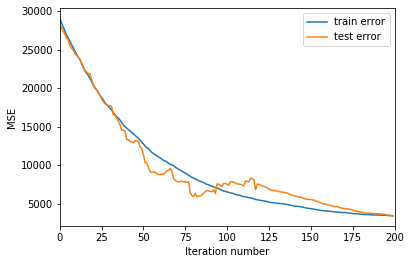

In [49]:
tree = GradientBoostingRegressor(learning_rate=0.01,
                                 n_estimators=50,
                                 max_depth=3,
                                 min_samples_leaf=2,
                                 min_samples_split=2)
tree.fit(X, X_test, y, y_test)
print(tree.evaluate(X, X_test, y, y_test))
tree.error_plot()

Преведена реализация сразу с использованием дерева из дз 4.
Реализован стахостический градиентный бустинг с использованием случайных выборок, для теста используются незадествованные значения, если значний остаётся меньше 1/2 размера выборки, то перестаём их уменьшать.

1 n_estimator


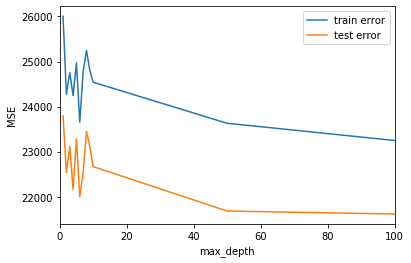

3 n_estimator


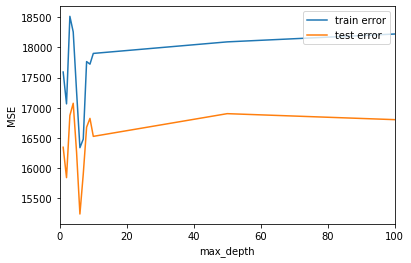

5 n_estimator


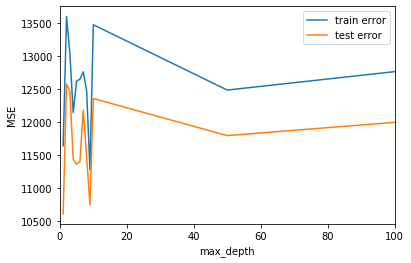

10 n_estimator


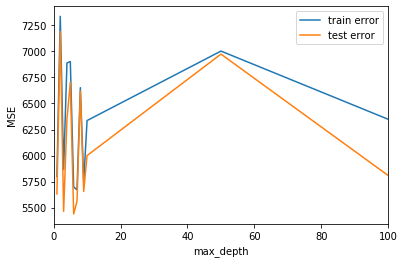

20 n_estimator


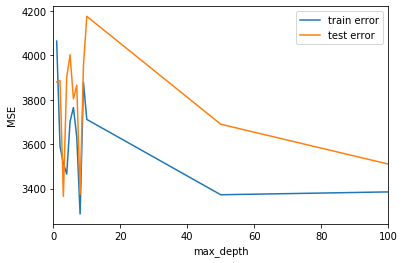

50 n_estimator


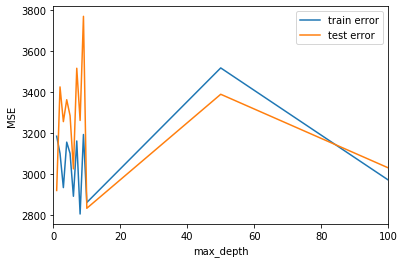

100 n_estimator


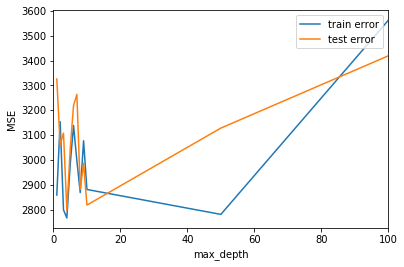

In [52]:
n_estimators = [1, 3, 5, 10, 20, 50, 100]
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100]
for n in n_estimators:
    error_list_max_depth_train = []
    error_list_max_depth_test = []
    for depth in max_depth:
        tree = GradientBoostingRegressor(learning_rate=0.1,
                                     n_estimators=n,
                                     max_depth=depth,
                                     min_samples_leaf=2,
                                     min_samples_split=2).fit(X, X_test, y, y_test)
        error_list_max_depth_train.append(tree.mean_squared_error(y_train, tree.predict(X_train)))
        error_list_max_depth_test.append(tree.mean_squared_error(y_test, tree.predict(X_test)))
    print(n, 'n_estimator')
    plt.xlabel('max_depth')
    plt.ylabel('MSE')
    plt.xlim(0, max(max_depth))
    plt.plot(max_depth, error_list_max_depth_train, label='train error')
    plt.plot(max_depth, error_list_max_depth_test, label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [53]:
# судя по графикам минимальная ошибка достгается при:
best_max_depth = 4
best_n_estimator = 100